/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 1398, number of used features: 7
[LightGBM] [Info] Start training from score 1.716023


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
          Modelo       MSE       MAE
5            SVR  1.252086  0.767485
4       LightGBM  1.305202  0.738487
1        SARIMAX  1.357252  0.824792
2        Prophet  1.416450  0.871562
7            GRU  1.605195  0.975814
3  Random Forest  1.795474  0.853839
6           LSTM  2.493510  1.173423
0          ARIMA  4.439912  1.726787


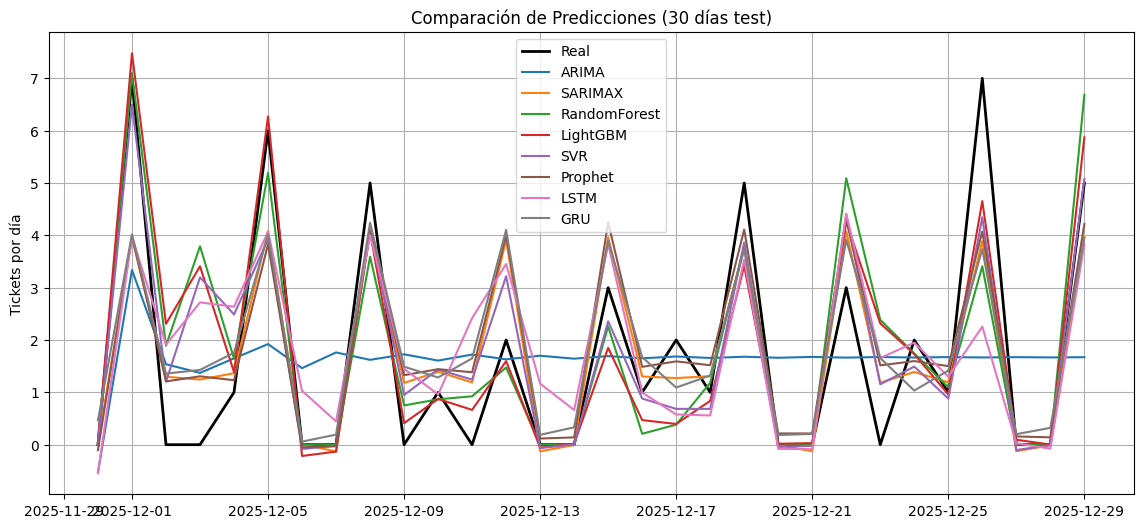

In [1]:
# =================================================
# 1. Instalación de librerías necesarias
# =================================================
!pip install prophet lightgbm keras --quiet

# =================================================
# 2. Importación y carga de datos
# =================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carga del dataset
df = pd.read_csv("tickets_fechas_reordenadas_2022_2025.csv")
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha'])
df['fecha_sola'] = df['fecha'].dt.date

# Serie diaria con número de tickets
serie = df.groupby('fecha_sola').size().reset_index(name='tickets_dia')
serie['fecha_sola'] = pd.to_datetime(serie['fecha_sola'])
serie = serie.set_index('fecha_sola').asfreq('D').fillna(0)

# =================================================
# 3. Ingeniería de variables (features)
# =================================================
serie['dow'] = serie.index.dayofweek             # Día de la semana (0=lun, 6=dom)
serie['is_end_week'] = (serie['dow'] >= 5).astype(int) # Fines de semana
serie['lag1'] = serie['tickets_dia'].shift(1)
serie['lag7'] = serie['tickets_dia'].shift(7)
serie['lag14'] = serie['tickets_dia'].shift(14)
serie['ma7'] = serie['tickets_dia'].rolling(7).mean()  # Media movil 7 días
serie['ma30'] = serie['tickets_dia'].rolling(30).mean()# Media movil 30 días
serie = serie.dropna()

# =================================================
# 4. División en entrenamiento y test (últimos 30 días como test)
# =================================================
train = serie.iloc[:-30]
test  = serie.iloc[-30:]

# =================================================
# 5. MODELOS ESTADÍSTICOS (ARIMA, SARIMAX, PROPHET)
# =================================================
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA simple
arima_model = ARIMA(train['tickets_dia'], order=(3,1,2)).fit()
pred_arima = arima_model.forecast(steps=30)

# SARIMAX con exógena (día de semana)
sarimax_model = SARIMAX(train['tickets_dia'], exog=train[['dow']],
                        order=(2,1,2), seasonal_order=(1,1,1,7)).fit()
pred_sarimax = sarimax_model.forecast(30, exog=test[['dow']])

# Prophet (requiere ds, y y regresores)
from prophet import Prophet
df_prophet = serie.reset_index().rename(columns={'fecha_sola':'ds','tickets_dia':'y'})
modelo_prophet = Prophet()
modelo_prophet.add_regressor('dow')
modelo_prophet.add_regressor('is_end_week')
modelo_prophet.fit(df_prophet[['ds','y','dow','is_end_week']].iloc[:-30])
future = df_prophet[['ds','dow','is_end_week']].iloc[-30:]
pred_prophet = modelo_prophet.predict(future)['yhat']

# =================================================
# 6. MACHINE LEARNING (Random Forest, LightGBM, SVR)
# =================================================
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

feats = ['dow','is_end_week','lag1','lag7','lag14','ma7','ma30']
X_train, X_test = train[feats], test[feats]
y_train, y_test = train['tickets_dia'], test['tickets_dia']

# Random Forest
rf = RandomForestRegressor(n_estimators=120, random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# LightGBM
gbm = LGBMRegressor(random_state=1)
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)

# SVR (Support Vector Regression)
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# =================================================
# 7. DEEP LEARNING (LSTM, GRU)
# =================================================
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
s_scaled = scaler.fit_transform(serie[['tickets_dia']])

# Función para crear secuencias
def create_sequences(data, n_steps=14):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(s_scaled, n_steps=14)
X_train_lstm, X_test_lstm = X_seq[:-30], X_seq[-30:]
y_train_lstm, y_test_lstm = y_seq[:-30], y_seq[-30:]

# LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(32, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=60, verbose=0)
y_pred_lstm = scaler.inverse_transform(model_lstm.predict(X_test_lstm))

# GRU
model_gru = Sequential()
model_gru.add(GRU(32, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train_lstm, y_train_lstm, epochs=60, verbose=0)
y_pred_gru = scaler.inverse_transform(model_gru.predict(X_test_lstm))

# =================================================
# 8. COMPARACIÓN DE MODELOS
# =================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error

resultados = pd.DataFrame({
    'Modelo': [
        'ARIMA', 'SARIMAX', 'Prophet',
        'Random Forest', 'LightGBM', 'SVR',
        'LSTM', 'GRU'
    ],
    'MSE': [
        mean_squared_error(y_test, pred_arima),
        mean_squared_error(y_test, pred_sarimax),
        mean_squared_error(y_test.reset_index(drop=True), pred_prophet),
        mean_squared_error(y_test, y_pred_rf),
        mean_squared_error(y_test, y_pred_gbm),
        mean_squared_error(y_test, y_pred_svr),
        mean_squared_error(y_test, y_pred_lstm),
        mean_squared_error(y_test, y_pred_gru)
    ],
    'MAE': [
        mean_absolute_error(y_test, pred_arima),
        mean_absolute_error(y_test, pred_sarimax),
        mean_absolute_error(y_test.reset_index(drop=True), pred_prophet),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_gbm),
        mean_absolute_error(y_test, y_pred_svr),
        mean_absolute_error(y_test, y_pred_lstm),
        mean_absolute_error(y_test, y_pred_gru)
    ]
})
print(resultados.sort_values('MSE'))

# =================================================
# 9. VISUALIZACIÓN Comparación visual de todos los modelos
# =================================================
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label='Real', color='black', linewidth=2)
plt.plot(y_test.index, pred_arima, label='ARIMA')
plt.plot(y_test.index, pred_sarimax, label='SARIMAX')
plt.plot(y_test.index, y_pred_rf, label='RandomForest')
plt.plot(y_test.index, y_pred_gbm, label='LightGBM')
plt.plot(y_test.index, y_pred_svr, label='SVR')
plt.plot(y_test.index, pred_prophet, label='Prophet')
plt.plot(y_test.index, y_pred_lstm, label='LSTM')
plt.plot(y_test.index, y_pred_gru, label='GRU')
plt.ylabel('Tickets por día')
plt.title('Comparación de Predicciones (30 días test)')
plt.legend()
plt.grid()
plt.show()


In [ ]:

# Volvemos a usar 'daily' con índice fecha
df_peaks = daily.copy()
df_peaks['dayofweek'] = df_peaks.index.dayofweek
df_peaks['weekday_name'] = df_peaks.index.day_name()
df_peaks['month'] = df_peaks.index.month
df_peaks['year'] = df_peaks.index.year

# 1) Tickets por día de la semana
tickets_by_weekday = df_peaks.groupby('weekday_name')['tickets'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

plt.figure()
tickets_by_weekday.plot(kind='bar')
plt.title('Tickets totales por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Total de tickets')
plt.xticks(rotation=45)
plt.show()

# 2) Tickets por mes (agregado)
tickets_by_month = df_peaks.groupby('month')['tickets'].sum()

plt.figure()
tickets_by_month.plot(kind='bar')
plt.title('Tickets totales por mes')
plt.xlabel('Mes')
plt.ylabel('Total de tickets')
plt.show()

# 3) Tickets por año
tickets_by_year = df_peaks.groupby('year')['tickets'].sum()

plt.figure()
tickets_by_year.plot(kind='bar')
plt.title('Tickets totales por año')
plt.xlabel('Año')
plt.ylabel('Total de tickets')
plt.show()

# 4) Top N días con mayor número de tickets
top_n = 10
top_days = df_peaks.sort_values('tickets', ascending=False).head(top_n)

print(f"Top {top_n} días con mayor número de tickets:")
display(top_days[['tickets']])

plt.figure()
plt.bar(top_days.index.astype(str), top_days['tickets'])
plt.title(f'Top {top_n} días con más tickets')
plt.xlabel('Fecha')
plt.ylabel('Tickets')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


NameError: name 'daily' is not defined